<a href="https://colab.research.google.com/github/heejeongJ/DL_pt/blob/Autoencoder-%234/Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **필요한 라이브러리 불러오기**

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torchvision.datasets as dset
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# **하이퍼 파라미터 지정**

In [2]:
batch_size = 256
learning_rate = 0.0002
num_epoch = 5

# **데이터 다운로드**

In [3]:
mnist_train = dset.MNIST("./", train=True, transform=transforms.ToTensor(), target_transform=None, download=True)
mnist_test = dset.MNIST("./", train=False, transform=transforms.ToTensor(), target_transform=None, download=True)

100%|██████████| 9912422/9912422 [00:00<00:00, 87694340.08it/s]


Extracting ./MNIST/raw/train-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 28881/28881 [00:00<00:00, 99454592.63it/s]


Extracting ./MNIST/raw/train-labels-idx1-ubyte.gz to ./MNIST/raw



100%|██████████| 1648877/1648877 [00:00<00:00, 28139574.63it/s]


Extracting ./MNIST/raw/t10k-images-idx3-ubyte.gz to ./MNIST/raw



100%|██████████| 4542/4542 [00:00<00:00, 7904783.72it/s]


Extracting ./MNIST/raw/t10k-labels-idx1-ubyte.gz to ./MNIST/raw



# **DataLoader 설정**

In [4]:
train_loader = torch.utils.data.DataLoader(mnist_train, batch_size=batch_size, shuffle=True, num_workers = 2, drop_last=True)
test_loader = torch.utils.data.DataLoader(mnist_test, batch_size=batch_size, shuffle=False, num_workers = 2, drop_last=True)

# **모델 선언**

In [15]:
class Autoencoder(nn.Module) :
  def __init__(self):
    super(Autoencoder, self).__init__()
    self.encoder = nn.Linear(28*28, 20)
    self.decoder = nn.Linear(20, 28*28)


  def forward(self, x) :
    x = x.view(batch_size, -1)
    encoded = self.encoder(x)
    out = self.decoder(encoded).view(batch_size, 1, 28, 28)
    return out

# **[합성곱] 모델 선언 - Encoder**

In [ ]:
class Encoder(nn.Module) :
  def __init__(self):
    super(Encoder, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(1, 16, 3, padding = 1),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.Conv2d(16, 32, 3, padding = 1),
        nn.ReLU(),
        nn.BatchNorm2d(32),
        nn.Conv2d(32, 64, 3, padding = 1),
        nn.ReLU(),
        nn.BatchNorm2d(64),
        nn.MaxPool2d(2, 2)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(64, 128, 3, padding = 1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.MaxPool2d(2, 2),
        nn.Conv2d(128, 256, 3, padding = 1),
        nn.ReLU()
    )

  def forward(self, x) :
    out = self.layer1(x)
    out = self.layer2(out)
    out = out.view(batch_size, -1)
    return out

# **[합성곱] 모델 선언 - Encoder**

In [ ]:
class Decoder(nn.Module) :
  def __init__(self):
    super(Decoder, self).__init__()
    self.layer1 = nn.Sequential(
        nn.ConvTranspose2d(256, 128, 3, 2, 1, 1),
        nn.ReLU(),
        nn.BatchNorm2d(128),
        nn.ConvTranspose2d(128, 64, 3, 1, 1),
        nn.ReLU(),
        nn.BatchNorm2d(64)
    )
    self.layer2 = nn.Sequential(
        nn.ConvTranspose2d(64, 16, 3, 1, 1),
        nn.ReLU(),
        nn.BatchNorm2d(16),
        nn.ConvTranspose2d(16, 1, 3, 2, 1, 1),
        nn.ReLU()
    )

  def forward(self, x) :
    out = self.view(batch_size, 256, 7, 7)
    out = self.layer1(out)
    out = self.layer2(out)
    return out

# **손실 함수, 최적화 함수**

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

model = Autoencoder().to(device)
loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

cuda:0


# **[합성곱] 손실 함수, 최적화 함수**

In [ ]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

encoder = Encoder().to(device)
decoder = Decoder().to(device)

parameters = list(encoder.parameters()) + list(decoder.parameters())

loss_func = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# **[합성곱] 학습**

In [ ]:
for i in range(num_epoch) :
  for j, [image, label] in enumerate(train_loader) :
    optimizer.zero_grad()
    image = image.to(device)

    output = encoder(image)
    output = decoder(output)

    loss = loss_func(output, image)
    loss.backward()
    optimizer.step()

# **학습**

In [17]:
loss_arr = []
for i in range(num_epoch):
  for j, [image, label] in enumerate(train_loader) :
    x = image.to(device)

    optimizer.zero_grad()
    output = model.forward(x)
    loss = loss_func(output, x)
    loss.backward()
    optimizer.step()

  if j % 1000 == 0 :
    print(loss)
    loss_arr.append(loss.cpu().data.numpy()[0])

# **훈련 영상을 통한 확인**

torch.Size([256, 28, 28])


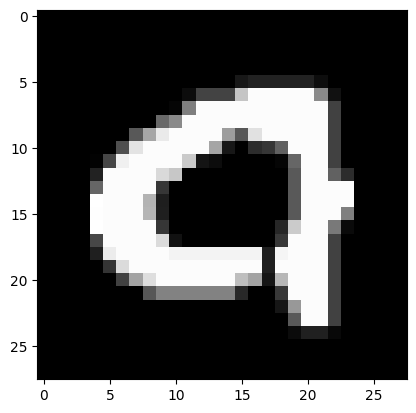

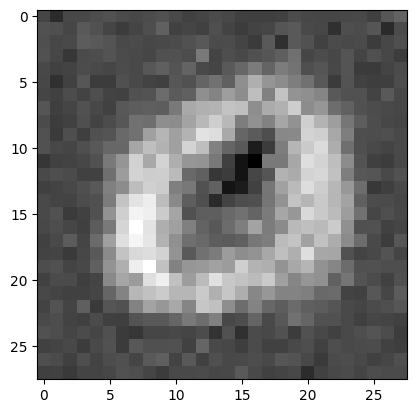

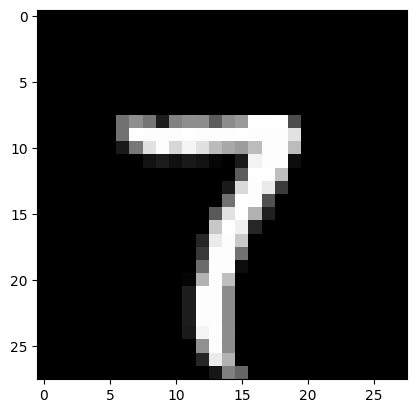

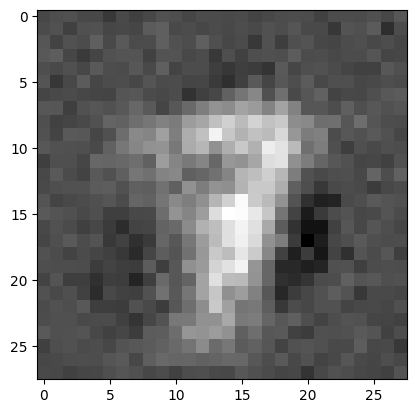

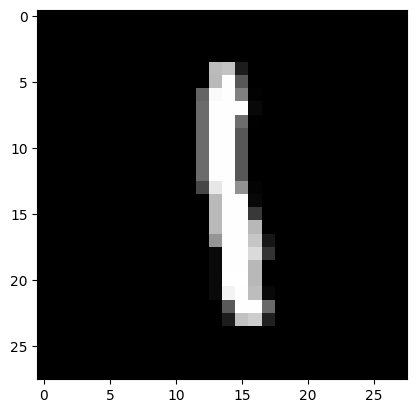

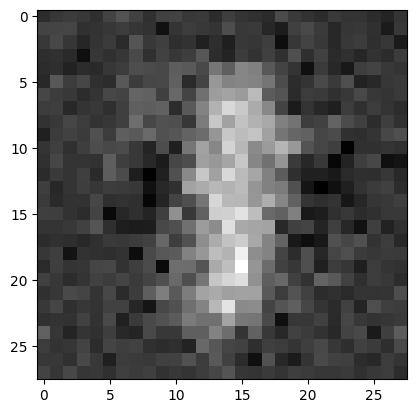

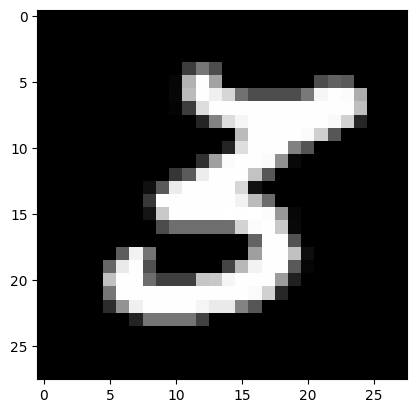

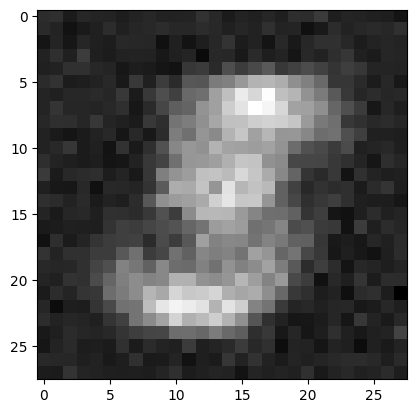

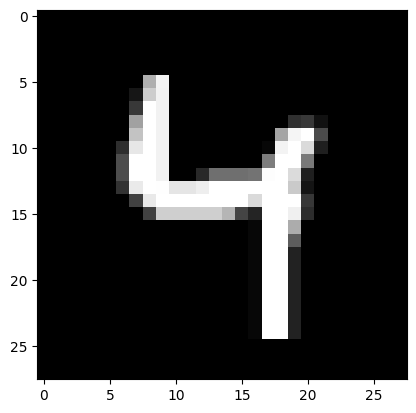

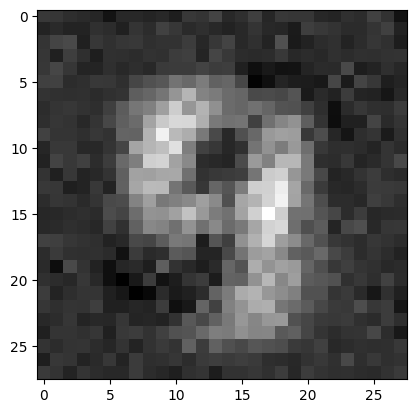

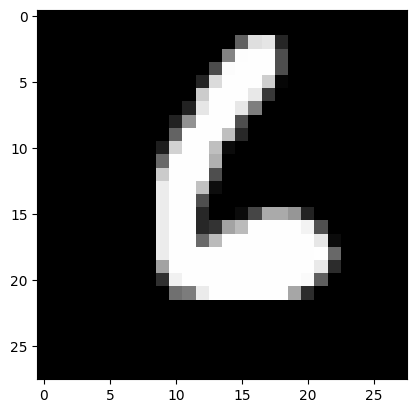

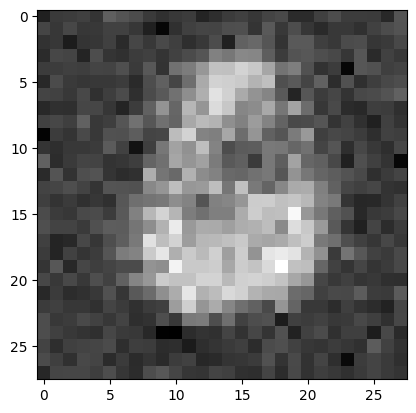

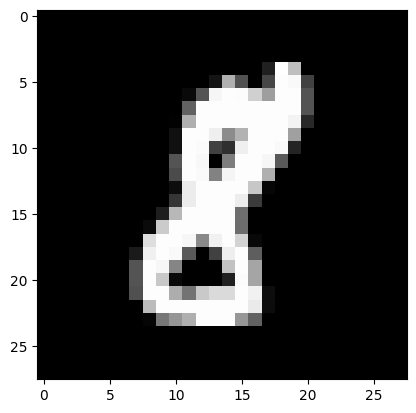

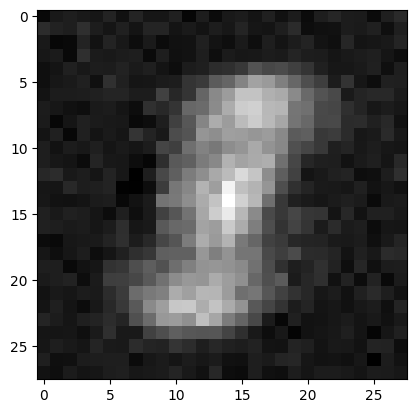

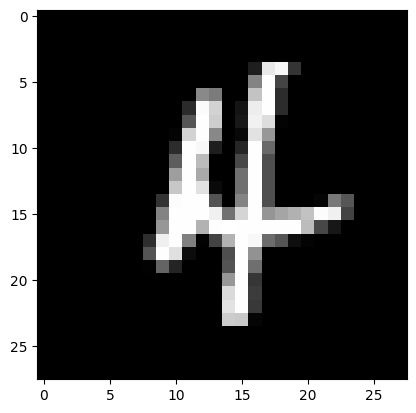

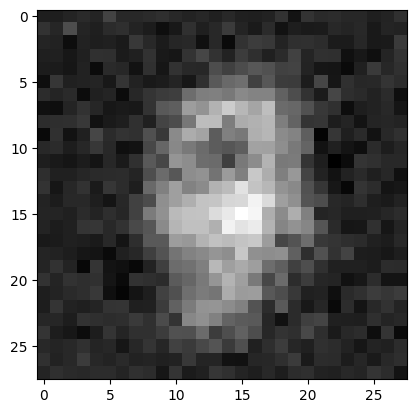

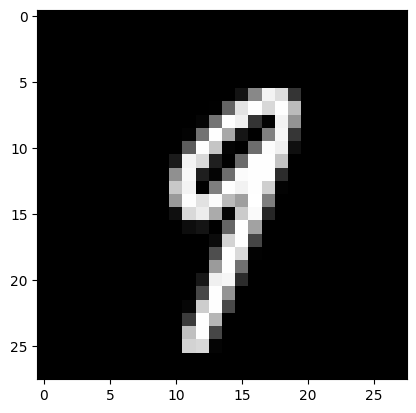

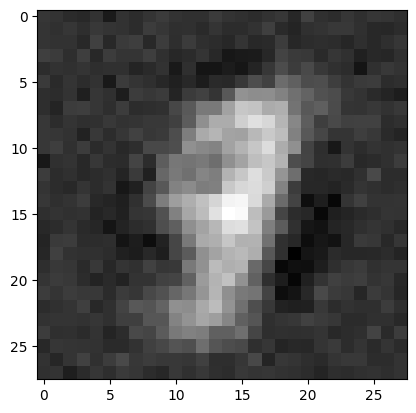

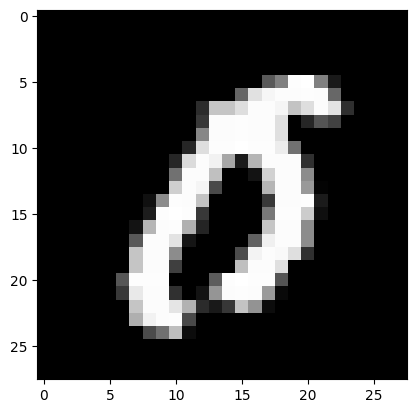

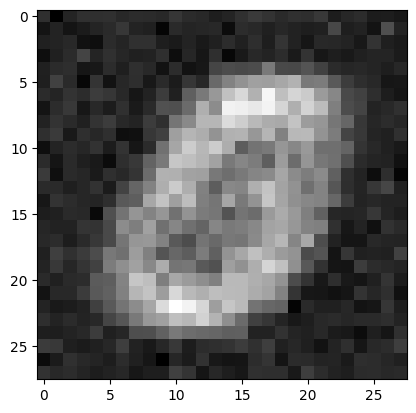

In [18]:
out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(10):
  plt.imshow(torch.squeeze(image[i]).numpy(), cmap='gray')
  plt.show()
  plt.imshow(out_img[i].numpy(), cmap='gray')
  plt.show()

# **테스트 수행**

In [19]:
with torch.no_grad():
  for i in range(1):
    for j, [image, label] in enumerate(test_loader):
      x = image.to(device)

      optimizer.zero_grad()
      output = model.forward(x)

    if j % 1000 == 0:
      print(loss)

# **테스트 영상을 통한 확인**

torch.Size([256, 28, 28])


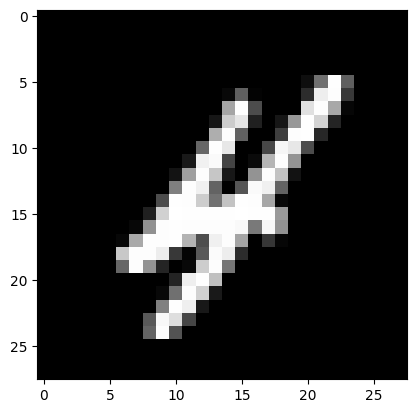

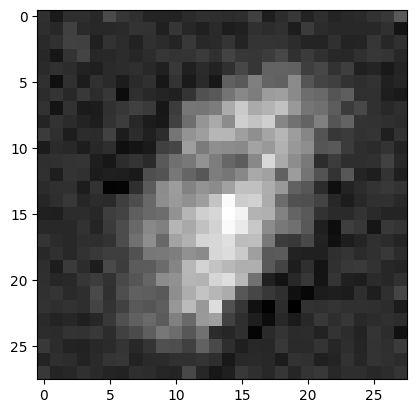

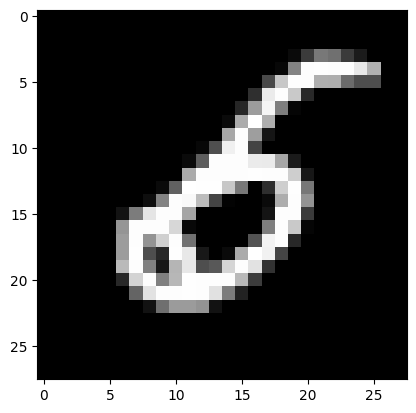

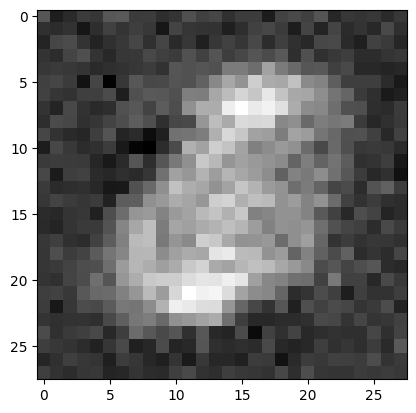

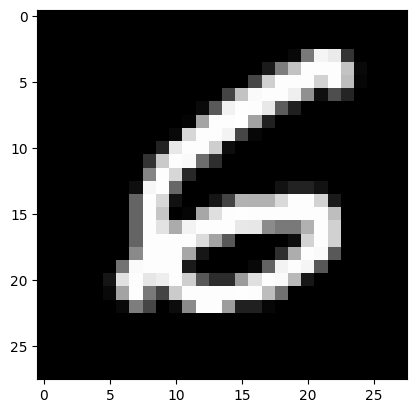

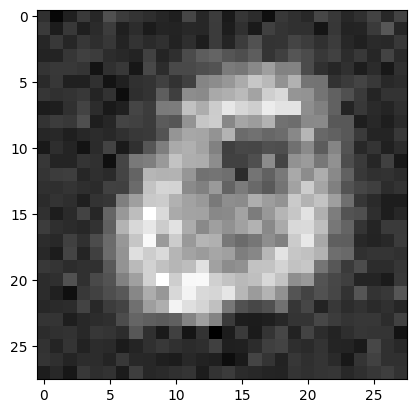

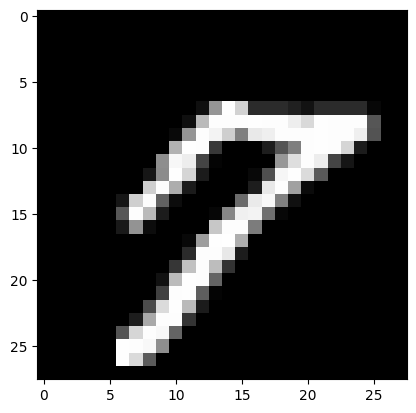

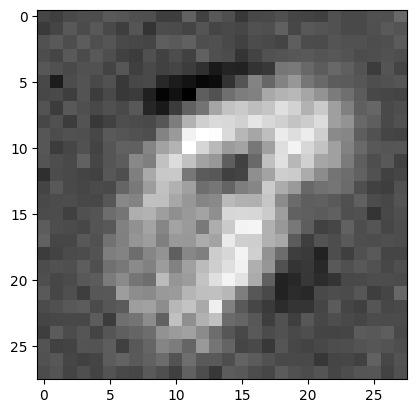

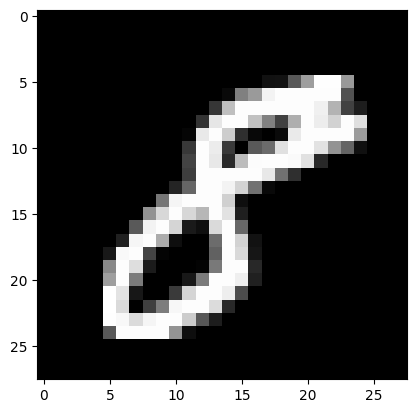

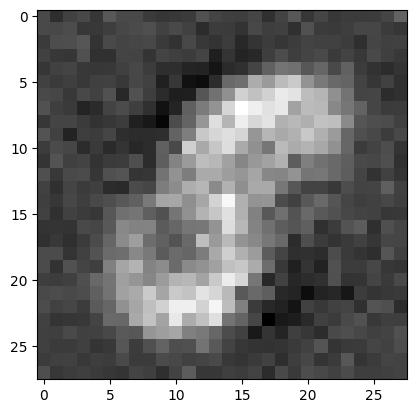

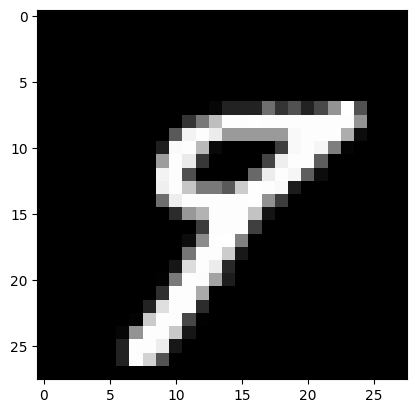

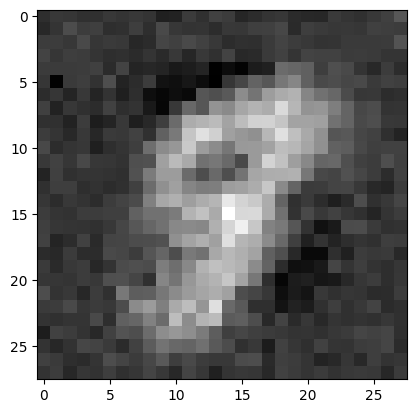

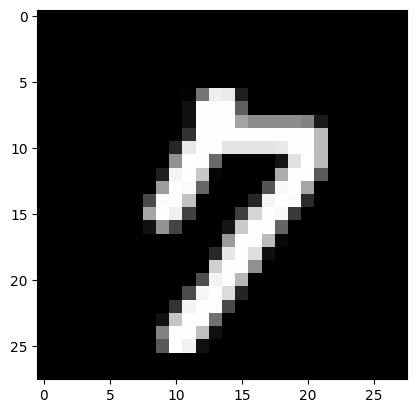

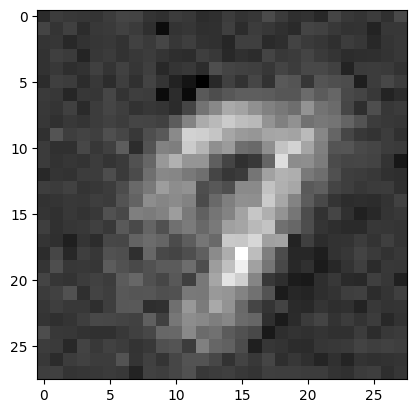

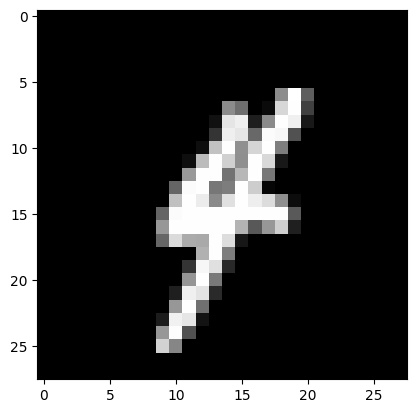

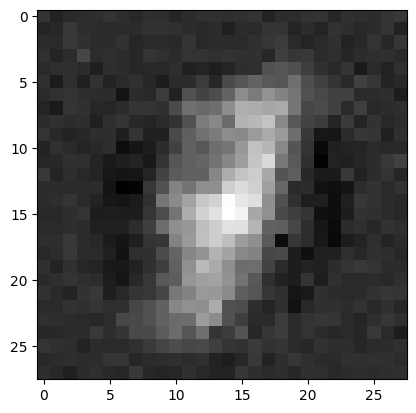

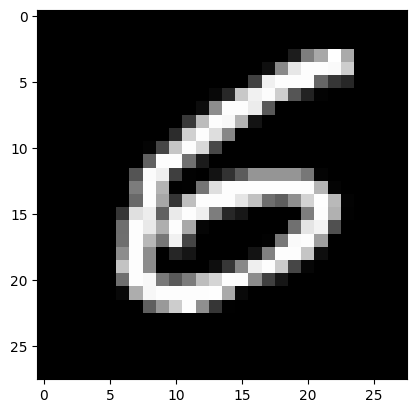

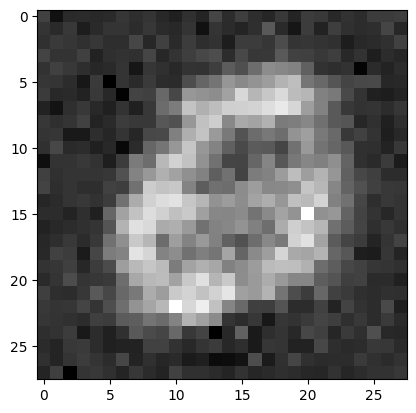

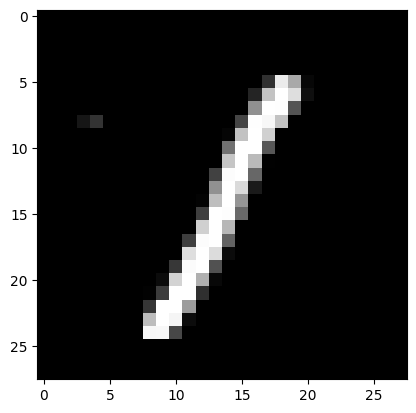

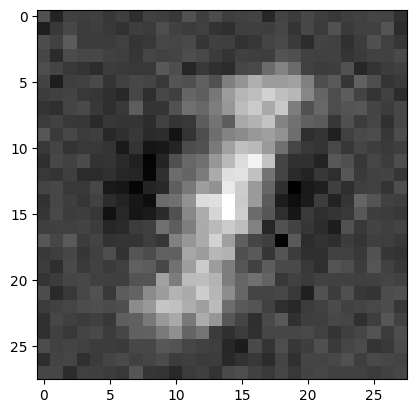

In [20]:
out_img = torch.squeeze(output.cpu().data)
print(out_img.size())

for i in range(10) :
  plt.imshow(torch.squeeze(image[i]).numpy(), cmap='gray')
  plt.show()
  plt.imshow(out_img[i].numpy(), cmap='gray')
  plt.show()